In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd

In [120]:
DATA_PATH = "./data/netflix_movies_single_genre.csv"

#### Import DataFrame and do some ETA

In [121]:
df = pd.read_csv(DATA_PATH)
df.head()



,Unnamed: 0,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre
0,0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['US'],1.0,NaN,NaN,NaN,0.600,NaN,documentation
1,1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,crime
2,2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,action
3,3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,comedy
4,4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,war


In [122]:
# summary of missing

def count_missing_values(df) -> Dict[str, int]:
  """
  Count the number of missing values

  Args:
      df: The pandas DataFrame to analyze

  Returns:
      A dictionary containing two keys:
          'total': The total number of missing values in the DataFrame.
          'by_column': A Series containing the number of missing values in each column.
  """
  # Detect missing values using isnull()
  missing_values = df.isnull().sum()

  # Count the total number of missing values
  total_missing = missing_values.sum()

  # Return the results as a dictionary
  return {
      'total': total_missing,
      'by_column': missing_values
  }

In [123]:
count_missing_values(df)

{'total': 7898,
 'by_column': Unnamed: 0                 0
 id                         0
 title                      0
 type                       0
 description               10
 release_year               0
 age_certification       2587
 runtime                    0
 production_countries       0
 seasons                 3710
 imdb_id                  353
 imdb_score               429
 imdb_votes               443
 tmdb_popularity           82
 tmdb_score               284
 genre                      0
 dtype: int64}

There are a number of missing values in the data but importantly there are a small number (10) in the description column that will need to be removed.  There are no missing values in the genre

In [124]:
CATEGORICAL_NAMES = ["type", "release_year", "age_certification", "seasons", "genre"]

for col in CATEGORICAL_NAMES:
    df[col] = df[col].astype('category')

In [125]:
def describe_df(df):
  """
  This function analyzes a pandas DataFrame and provides summary statistics.

  Args:
      df: The pandas DataFrame to analyze.

  Returns:
      A dictionary containing summary statistics for each column:
          - categorical columns: frequency counts
          - numeric columns: mean, minimum, and maximum values
  """
  results = {}
  for col in df.columns:
    # Identify data type
    if isinstance(df[col].dtype, pd.CategoricalDtype):
      # Categorical data: count frequencies
      results[col] = df[col].value_counts().sort_values(ascending=False)
    elif pd.api.types.is_numeric_dtype(df[col]):
      # Numeric data: calculate mean, min, max
      results[col] = {
          'mean': df[col].mean(),
          'min': df[col].min(),
          'max': df[col].max()
      }
    else:
      # Other data types: handle as needed (e.g., count unique values)
      results[col] = 'Non-numeric, Non-categorical'

  return results

In [126]:
df_analysis = describe_df(df)
df_analysis

{'Unnamed: 0': {'mean': 2895.0, 'min': 0, 'max': 5790},
 'id': 'Non-numeric, Non-categorical',
 'title': 'Non-numeric, Non-categorical',
 'type': type
 MOVIE    3710
 SHOW     2081
 Name: count, dtype: int64,
 'description': 'Non-numeric, Non-categorical',
 'release_year': release_year
 2019    829
 2020    806
 2021    770
 2018    763
 2017    559
        ... 
 1973      1
 1974      1
 1977      1
 1985      1
 1945      1
 Name: count, Length: 63, dtype: int64,
 'age_certification': age_certification
 TV-MA    878
 R        553
 TV-14    470
 PG-13    450
 PG       233
 TV-PG    183
 G        121
 TV-Y7    118
 TV-Y     104
 TV-G      78
 NC-17     16
 Name: count, dtype: int64,
 'runtime': {'mean': 77.23847349335175, 'min': 0, 'max': 240},
 'production_countries': 'Non-numeric, Non-categorical',
 'seasons': seasons
 1.0     1200
 2.0      388
 3.0      186
 4.0      118
 5.0       79
 6.0       36
 7.0       18
 8.0       11
 9.0        9
 11.0       8
 10.0       6
 12.0       4


In [187]:
def generate_feature_plots(feat, target, df):
    
    sns.set(
        style="whitegrid",
        palette="deep",
        font_scale=1.1,
        rc={"figure.figsize": [15, len(feat) * 6.5]}
    )

    iter = 1

    plt.figure()

    for i in range(0, len(feat)):
        print(f"Generate plots for feature {feat[i]}")

        if df[feat[i]].dtypes == "category":
            plt.subplot(len(feat), 1, iter)
            counts = df.loc[:, [target, feat[i]]].value_counts().reset_index()
            
            contingency_table = pd.pivot_table(
                counts, values='count', index=feat[i], columns=target, aggfunc='sum'
            )

            contingency_table  = contingency_table .div(contingency_table .sum(axis=1), axis=0) * 100

            sns.heatmap(contingency_table, annot=True) 
            
            iter = iter + 2

        # If feature is numeric
        else:
            plt.subplot(len(feat), 2, iter)
            sns.histplot(df[feat[i]], kde=True).set(
                xlabel=feat[i],
                ylabel="Count",
                title="histogram of {}".format(feat[i]),
            )

            # Boxplot
            plt.subplot(len(feat), 2, iter+1)
            sns.boxplot(x=df[target], y=df[feat[i]]).set(
                title="box Plot of {} against target".format(feat[i])
            )
            plt.xticks(rotation=90) 

            iter = iter + 2

Generate plots for feature imdb_score


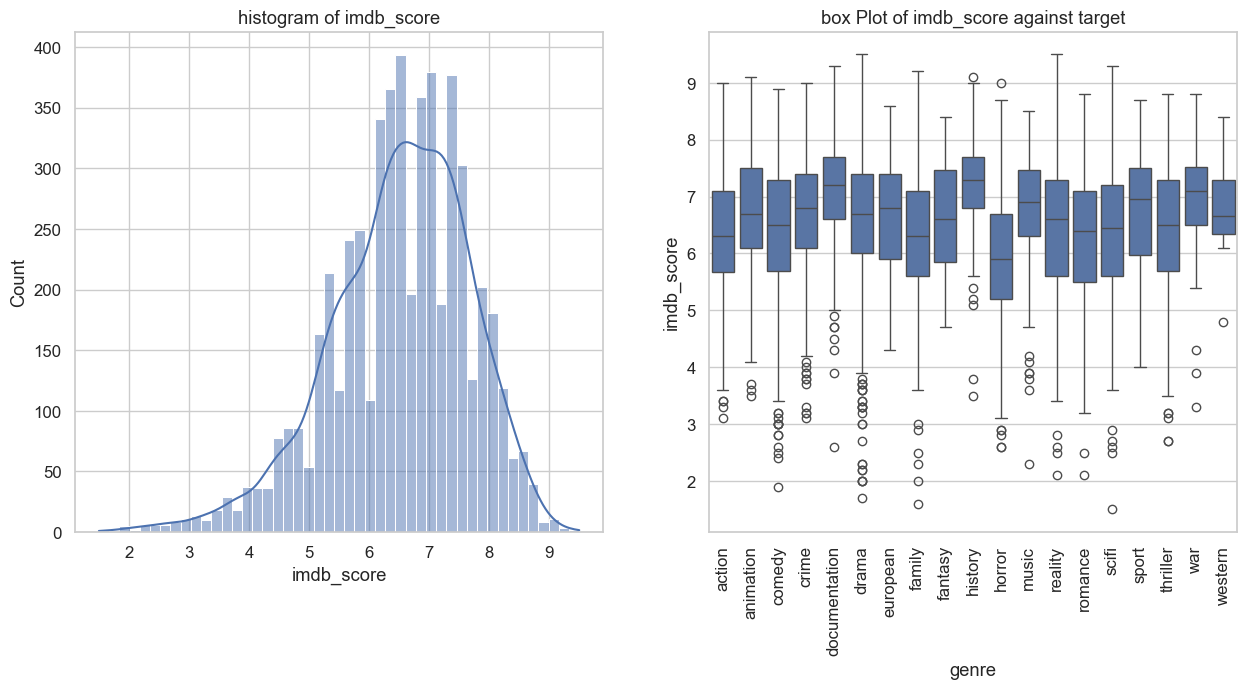

In [188]:
generate_feature_plots(["imdb_score"], "genre", df[["imdb_score", "genre"]])

Generate plots for feature runtime


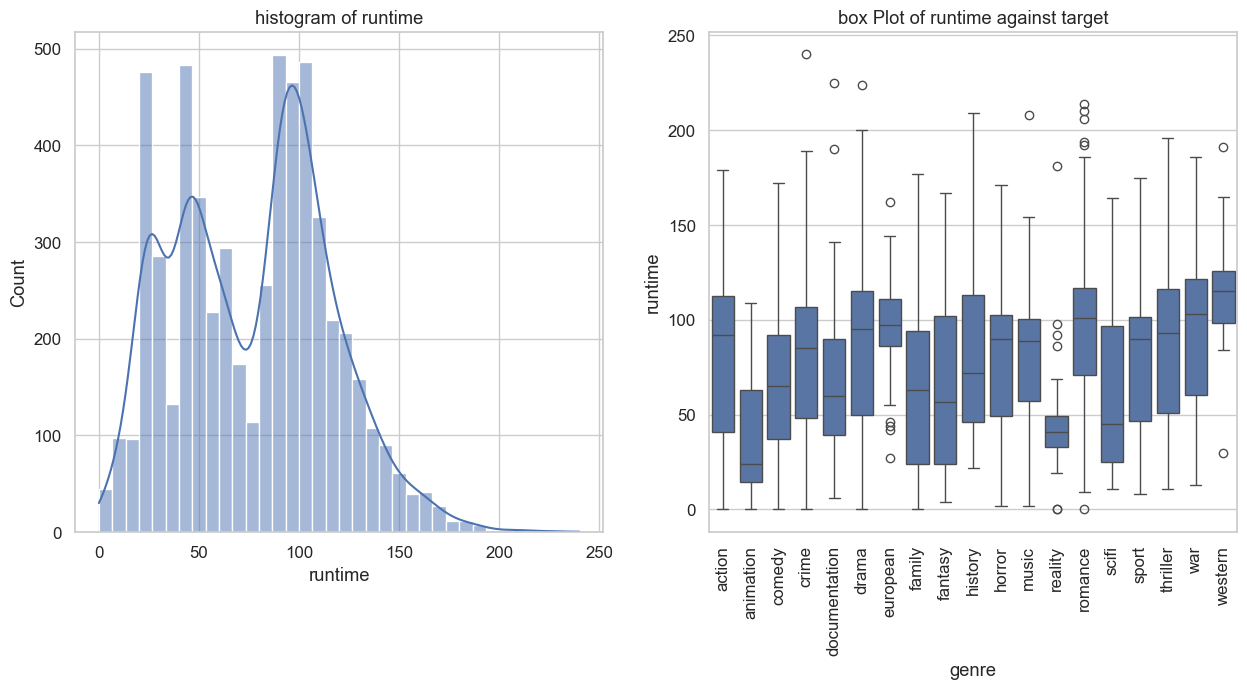

In [189]:
generate_feature_plots(["runtime"], "genre", df[["runtime", "genre"]])

Generate plots for feature imdb_votes


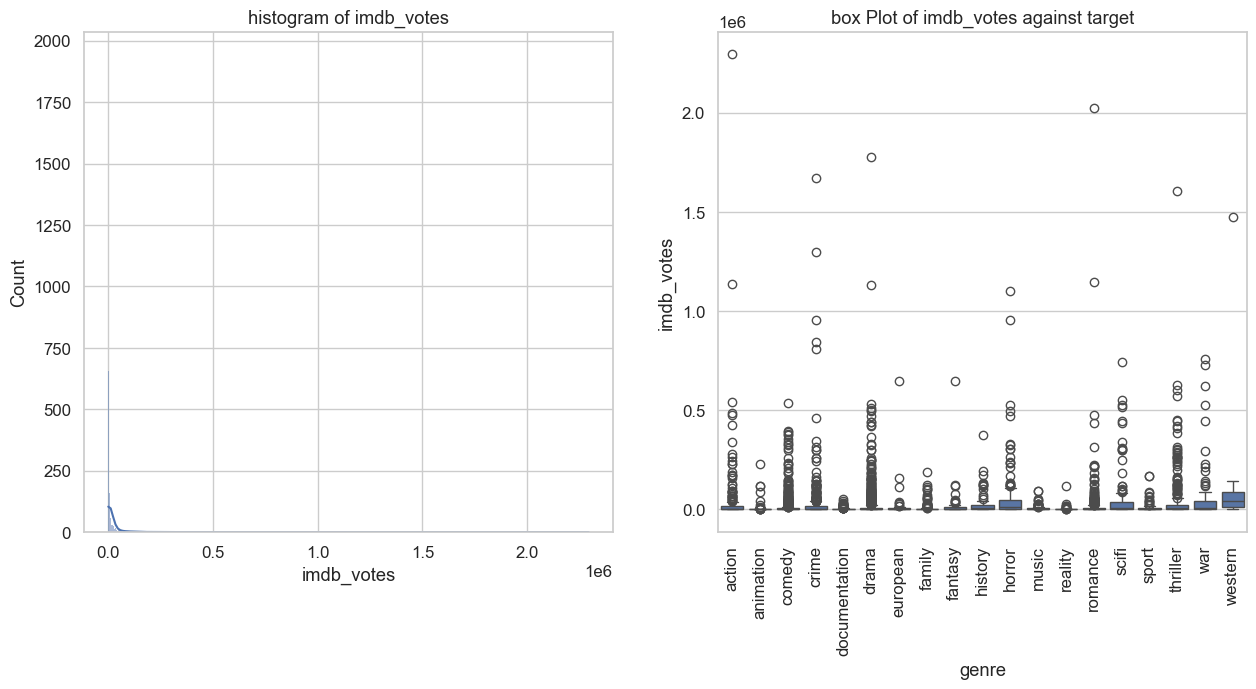

In [190]:
generate_feature_plots(["imdb_votes"], "genre", df[["imdb_votes", "genre"]])

Generate plots for feature tmdb_popularity


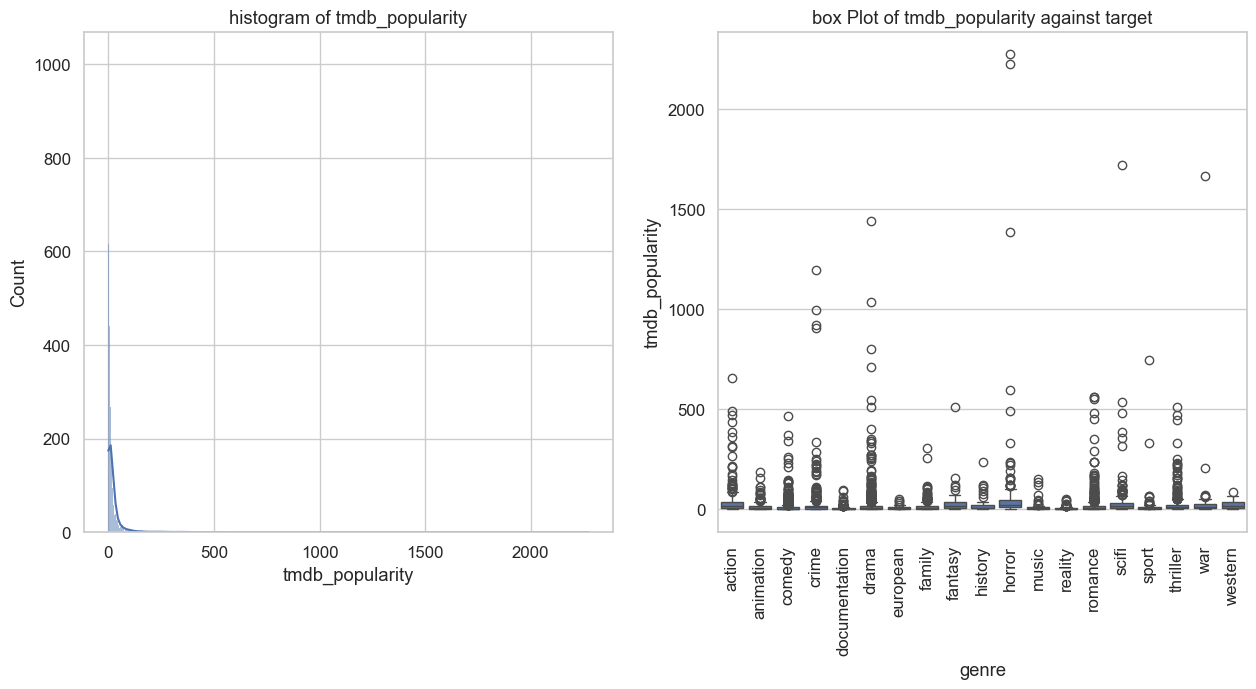

In [191]:
generate_feature_plots(["tmdb_popularity"], "genre", df[["tmdb_popularity", "genre"]])

Generate plots for feature tmdb_score


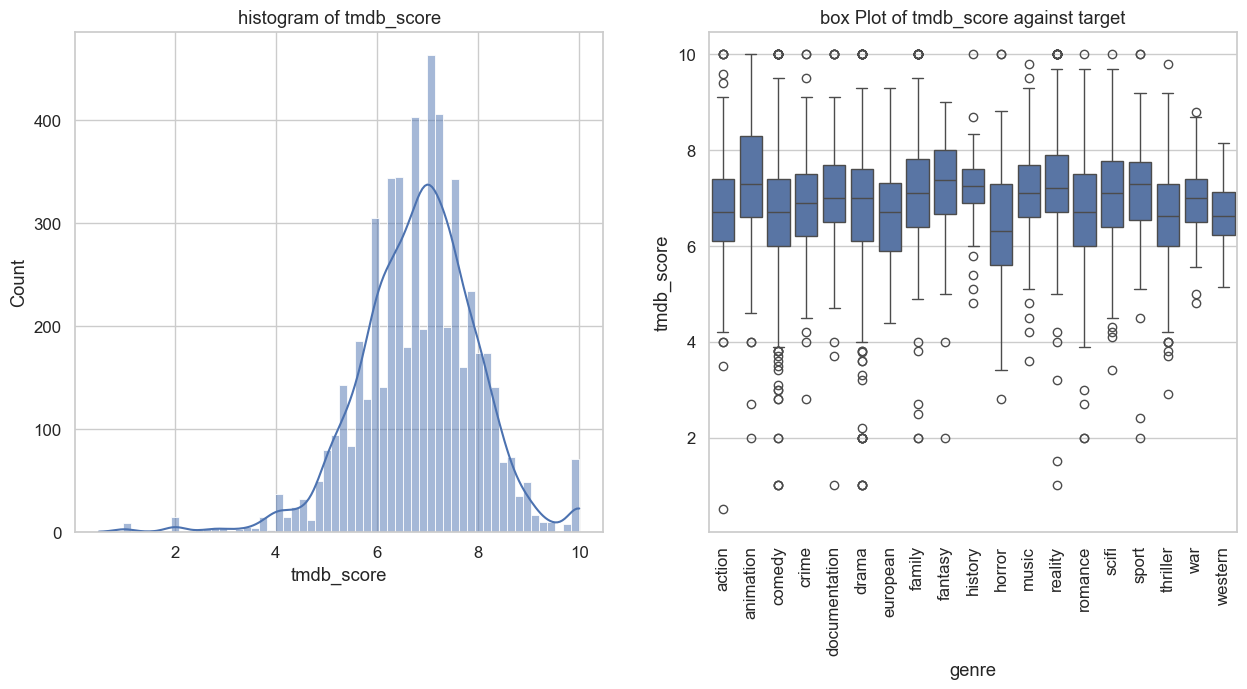

In [192]:
generate_feature_plots(["tmdb_score"], "genre", df[["tmdb_score", "genre"]])

Generate plots for feature age_certification


/var/folders/q8/kkfcr4054vqbwmd2_c2ks85r0000gn/T/ipykernel_54967/782325.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  contingency_table = pd.pivot_table(


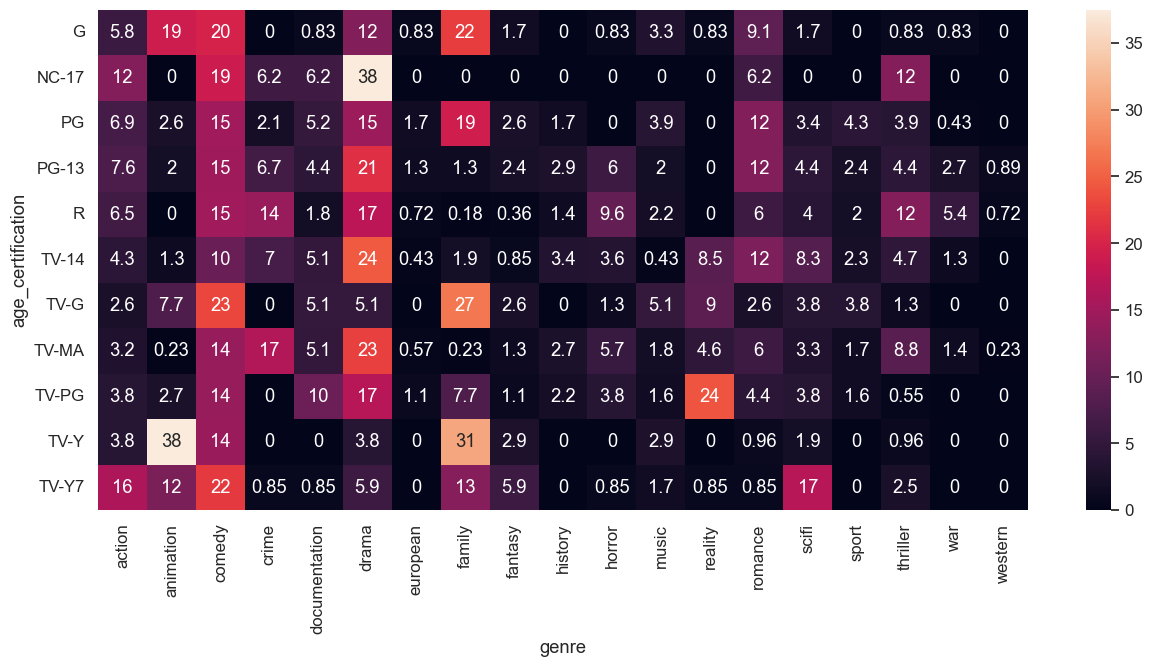

In [193]:
generate_feature_plots(["age_certification"], "genre", df[["age_certification", "genre"]])

Generate plots for feature type


/var/folders/q8/kkfcr4054vqbwmd2_c2ks85r0000gn/T/ipykernel_54967/782325.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  contingency_table = pd.pivot_table(


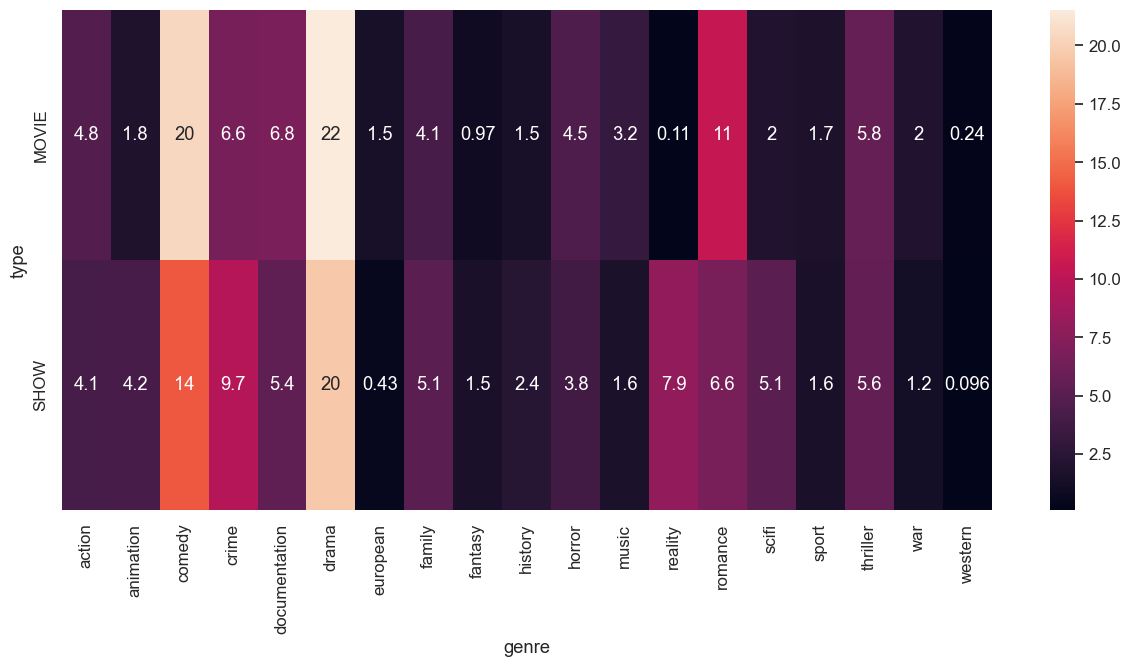

In [194]:
generate_feature_plots(["type"], "genre", df[["type", "genre"]])

In [196]:
df["release_year"].value_counts()

release_year
2019    829
2020    806
2021    770
2018    763
2017    559
       ... 
1973      1
1974      1
1977      1
1985      1
1945      1
Name: count, Length: 63, dtype: int64

In [227]:
counts = df.groupby('release_year')['genre'].value_counts().reset_index()
counts.groupby(['release_year']).head(1)


/var/folders/q8/kkfcr4054vqbwmd2_c2ks85r0000gn/T/ipykernel_54967/3506291177.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('release_year')['genre'].value_counts().reset_index()
/var/folders/q8/kkfcr4054vqbwmd2_c2ks85r0000gn/T/ipykernel_54967/3506291177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts.groupby(['release_year']).head(1)


,release_year,genre,count
0,1945,documentation,1
19,1954,drama,1
38,1956,drama,1
57,1958,drama,1
76,1959,crime,1
...,...,...,...
1102,2018,comedy,157
1121,2019,drama,173
1140,2020,drama,154
1159,2021,drama,162
